In [ ]:
!pip install tidecv -q

In [ ]:
from tidecv import TIDE, datasets, Data
from glob import glob
import os

In [ ]:
datasets.COCO().annotations

In [ ]:
!unzip -q archive.zip -d data
!unzip -q labels.zip -d predictions

replace data/coco128/LICENSE? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [ ]:
def load_custom_yolov5_datasets(name:str, image_dir:str, label_dir:str, class_names:list):
    # Create instance
    data = Data(name)

    # Add classes
    for idx, class_name in enumerate(class_names):
	    data.add_class(idx, class_name)

    # Import custom images and labels
    image_paths = sorted(glob(f'{image_dir}/*'))

    for idx, image_path in enumerate(image_paths[:1]):
        # Add image
        image_name = image_path.split('/')[-1]
        data.add_image(idx, image_name)

        # Add labels
        label_path = os.path.join(label_dir, image_name.split('.')[0]+'.txt')
        if not os.path.exists(label_path):
            continue

        with open(label_path, 'r') as f:
            dets = f.read().splitlines()
            for det in dets:
                class_id, box_info = det.split(' ', 1)
                class_id = int(class_id)
                box_info = list(map(float, box_info.split(' ')))
                x_c, y_c, w, h = box_info[:4]
                x_tl = x_c - w//2
                y_tl = y_c - h//2
                bbox = [x_tl, y_tl, w, h]
                if len(box_info) == 5:
                    score = box_info[-1]
                else:
                    score = None
                data.add_detection(image_id=idx,
                                   class_id=class_id,
                                   box=bbox,
                                   score=score)


    return data

In [ ]:
coco_classes = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
        'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
        'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
        'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
        'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
        'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
        'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
        'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear',
        'hair drier', 'toothbrush'] 

In [ ]:
data_gt = load_custom_yolov5_datasets('yolov5', 
                     '/content/data/coco128/images/train2017', 
                     '/content/data/coco128/labels/train2017',
                     class_names = coco_classes)

In [ ]:
data_pred = load_custom_yolov5_datasets('yolov5', 
                     '/content/data/coco128/images/train2017', 
                     '/content/predictions/labels',
                     class_names = coco_classes)

-- yolov5 --

bbox AP @ 50: 66.58

                         Main Errors
  Type      Cls      Loc     Both     Dupe      Bkg     Miss  
-------------------------------------------------------------
   dAP    33.42     0.00     0.00     0.00     0.00     0.00  

        Special Error
  Type   FalsePos   FalseNeg  
-----------------------------
   dAP       0.00       8.42  



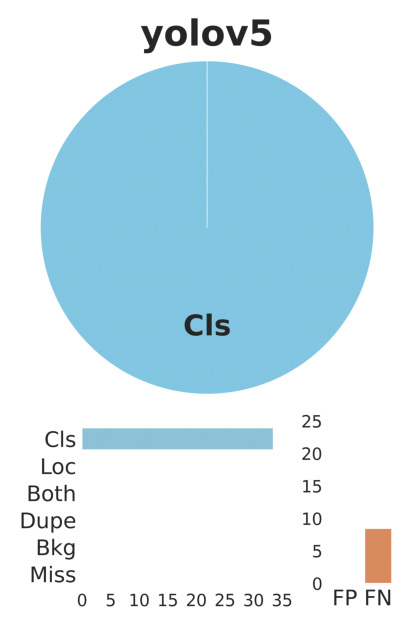

In [ ]:
tide = TIDE()
tide.evaluate(data_gt, data_pred, mode=TIDE.BOX) # Use TIDE.MASK for masks
tide.summarize()  # Summarize the results as tables in the console
tide.plot() 